<a href="https://colab.research.google.com/github/juanpajedrez/pytorch_learning/blob/main/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [161]:
# Check for GPU
!nvidia-smi

Tue Jun  3 21:50:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             29W /   70W |     350MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [162]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.6.0+cu124


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

From a model's perspective, we can do the following:
- **Add more layers**: Give the model more chances to learn about patterns in the data.
- **Add more Hidden Units**: Give each layer more hidden units to better represent the feature spaces.
- **Add non-linear transformations across layers**: For each layer, use a non-lienar transformation for better expressitivity.
- **Increase model complexity**: Rather than using only `nn.Linear()`, we can use `nn.Conv2d()`, or use much more complex architectures like: Transformers, LSTMs, or Generative AI ones.
- **Increase Data size and Data Variability**: There might be too little examples from the `P_{data}`, with little different variants for each possible `P_{label}`; therefore we might need way more data.
- **Fit for longer**: It could be that during the training and validation phase, there wasn't enought time to train the model. More training might help.
- **Lower Regularization** If any Regularization is being added while backpropagation, then lower it's strength so the model can fit better to the trianing data.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [163]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup a datapath to a data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"Did not find {image_path}, creating one directory...")
  image_path.mkdir(parents = True, exist_ok=True)

#Setup the variable where we are gonna get the data from:
request_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip"

# Using a context manager, open a path with writing in binary to download the data in zip format
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get(request_url)
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, and sushi
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak, sushi data...


In [164]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [165]:
# Setup train and testing paths
train_path = image_path / "train"
test_path = image_path / "test"

train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/sushi/2019344.jpg
Image class: sushi
Image height: 287
Image width: 512


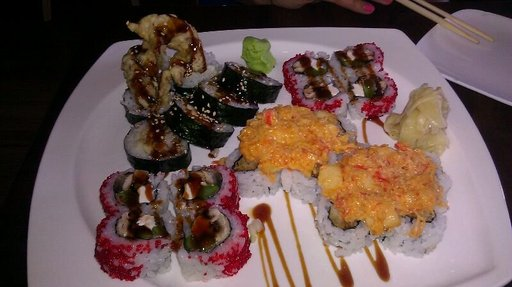

In [166]:
import random
from PIL import Image

# 1 Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3, Get the image class from path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

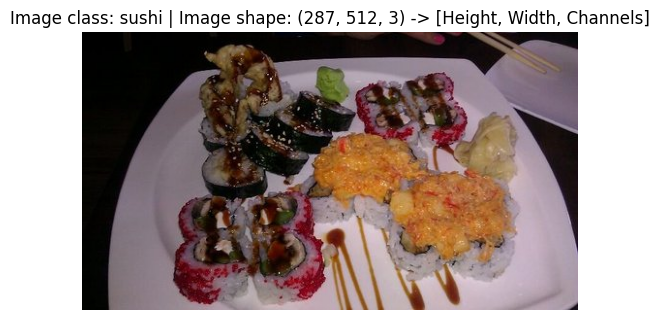

In [167]:
import matplotlib.pyplot as plt
import numpy as np

# Do the image visualization with matplotlib
img_as_array = np.asarray(img)

fig, ax = plt.subplots(1, 1)
ax.imshow(img_as_array)
ax.title.set_text(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [Height, Width, Channels]")
ax.axis("off")
plt.show()


We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [168]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 3.1 Transforming data with torchvision.transforms


In [169]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize((64, 64)),
    # Turn the image to a tensor
    transforms.ToTensor()
])


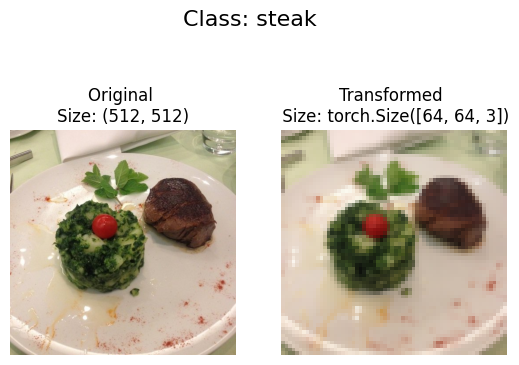

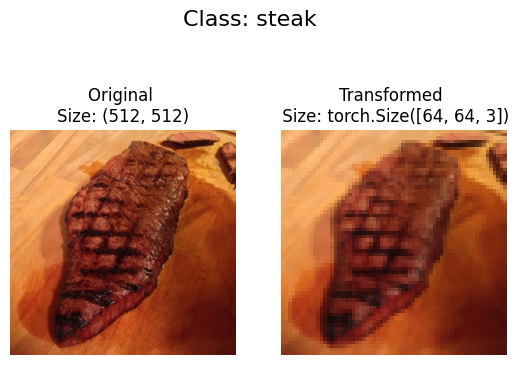

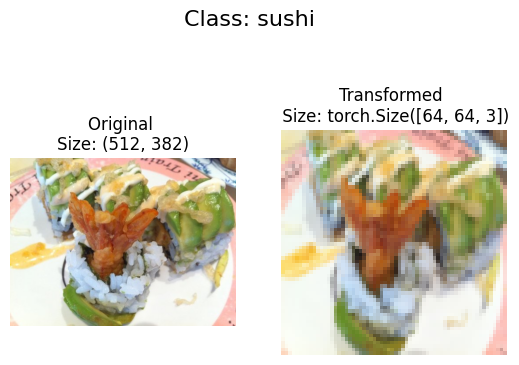

In [170]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths:list, transform:transforms.Compose, n:int = 3, seed:int = 42):
  '''
  Selects random images from a path of images and loads/transforms. Then it plots the original
  against the transformed version
  '''
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot the target image
      transformed_image = transform(f).permute(1, 2, 0) # Note we need to change shape for matplotlib
      # We changed the order from (C, H , W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

# Use the function to open the transform
plot_transformed_images(image_path_list, data_transform)

### Load image data using `ImageFolder`

In [171]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(
    root = train_path,
    transform = data_transform, # A transform for the data
    target_transform = None # A transform for the labels
)

test_data = datasets.ImageFolder(
    root = test_path,
    transform = data_transform, # A transform for the data
    target_transform = None # A transform for the labels
)

#Print the datasets
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [172]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [173]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [174]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [175]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size= BATCH_SIZE,
    num_workers = os.cpu_count(),
    shuffle = False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d6794387050>,
 <torch.utils.data.dataloader.DataLoader at 0x7d67943def50>)

In [176]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))
print(f"Image batch shape: {img.shape}")
print(f"Label batch shape: {label.shape}")


Image batch shape: torch.Size([32, 3, 64, 64])
Label batch shape: torch.Size([32])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [177]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:
    super().__init__()

    #Create block 1 of the tiny VGG
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                    stride = 2)
    )

    #Create block 2 of the tiny VGG
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                    stride = 2)
    )

    # Create a classifier layer
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
          in_features = int(hidden_units*13*13),
          out_features= output_shape)
        )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

# Create an instance of a model
tiny_vgg_model = TinyVGG(input_shape=3,
                         hidden_units = 10,
                         output_shape = len(class_names)).to(device)
print(tiny_vgg_model)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)


In [178]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))
print(f"Image batch shape: {img.shape}")
print(f"Label batch shape: {label.shape}")

# Install torch info, import it if its available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(tiny_vgg_model, input_size=(1, 3, 64, 64))

Image batch shape: torch.Size([32, 3, 64, 64])
Label batch shape: torch.Size([32])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [179]:
# Lets test the model with torch inference mode to see dimensions
tiny_vgg_model.eval()
with torch.inference_mode():
  y_logits = tiny_vgg_model(img.to(device)) # Remember that first dimensions is (N * C * H * W)
  # This works only with Batches
print(y_logits.shape)

torch.Size([32, 3])


## 4. Create training and testing functions for `model_0`.

In [180]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):

    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_logits = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_logits)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc


In [192]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      y_pred_class = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
      test_acc = (y_pred_class == y).sum().item()/len(y_pred_class)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc


In [193]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [194]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs here
EPOCHS = 5

# Create an instance of a model
tiny_vgg_model = TinyVGG(input_shape=3,
                         hidden_units = 10,
                         output_shape = len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=tiny_vgg_model.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
results = train(model = tiny_vgg_model,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

# End the timer and print out how long it took
end_time = timer()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.0303
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.2424
Epoch: 4 | train_loss: 1.0845 | train_acc: 0.4023 | test_loss: 1.0607 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0663 | train_acc: 0.4219 | test_loss: 1.0656 | test_acc: 0.2727


In [195]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs here
EPOCHS = 20

# Create an instance of a model
tiny_vgg_model = TinyVGG(input_shape=3,
                         hidden_units = 10,
                         output_shape = len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=tiny_vgg_model.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
results = train(model = tiny_vgg_model,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

# End the timer and print out how long it took
end_time = timer()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.0303
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.2424
Epoch: 4 | train_loss: 1.0844 | train_acc: 0.4023 | test_loss: 1.0607 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0663 | train_acc: 0.4141 | test_loss: 1.0656 | test_acc: 0.2727
Epoch: 6 | train_loss: 1.0303 | train_acc: 0.4375 | test_loss: 1.0135 | test_acc: 0.3030
Epoch: 7 | train_loss: 0.9818 | train_acc: 0.4180 | test_loss: 0.9342 | test_acc: 0.3333
Epoch: 8 | train_loss: 0.9490 | train_acc: 0.5469 | test_loss: 1.0258 | test_acc: 0.1515
Epoch: 9 | train_loss: 0.9253 | train_acc: 0.5859 | test_loss: 1.1035 | test_acc: 0.0303
Epoch: 10 | train_loss: 0.9849 | train_acc: 0.4609 | test_loss: 1.0130 | test_acc: 0.1212
Epoch: 11 | train_loss: 0.8628 | train_acc: 0.5234 | test_loss: 0.9585 | test_acc: 0.3333
Epoch: 12 | train_l

In [185]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs here
EPOCHS = 50

# Create an instance of a model
tiny_vgg_model = TinyVGG(input_shape=3,
                         hidden_units = 10,
                         output_shape = len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=tiny_vgg_model.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
results = train(model = tiny_vgg_model,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

# End the timer and print out how long it took
end_time = timer()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.0303
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.2424
Epoch: 4 | train_loss: 1.0846 | train_acc: 0.4023 | test_loss: 1.0606 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0664 | train_acc: 0.4180 | test_loss: 1.0660 | test_acc: 0.2727
Epoch: 6 | train_loss: 1.0311 | train_acc: 0.4414 | test_loss: 1.0155 | test_acc: 0.3030
Epoch: 7 | train_loss: 0.9879 | train_acc: 0.4219 | test_loss: 0.9352 | test_acc: 0.3333
Epoch: 8 | train_loss: 0.9600 | train_acc: 0.5859 | test_loss: 1.0045 | test_acc: 0.1515
Epoch: 9 | train_loss: 0.9177 | train_acc: 0.6016 | test_loss: 1.0696 | test_acc: 0.0303
Epoch: 10 | train_loss: 0.9850 | train_acc: 0.4727 | test_loss: 1.0288 | test_acc: 0.0909
Epoch: 11 | train_loss: 0.8525 | train_acc: 0.5312 | test_loss: 0.9691 | test_acc: 0.3333
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [186]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs here
EPOCHS = 20

# Create an instance of a model
tiny_vgg_model = TinyVGG(input_shape=3,
                         hidden_units = 20,
                         output_shape = len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=tiny_vgg_model.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
results = train(model = tiny_vgg_model,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

# End the timer and print out how long it took
end_time = timer()


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1031 | train_acc: 0.2852 | test_loss: 1.1013 | test_acc: 0.0000
Epoch: 2 | train_loss: 1.1016 | train_acc: 0.2930 | test_loss: 1.1019 | test_acc: 0.0000
Epoch: 3 | train_loss: 1.1001 | train_acc: 0.2539 | test_loss: 1.0894 | test_acc: 0.2121
Epoch: 4 | train_loss: 1.1116 | train_acc: 0.3047 | test_loss: 1.0924 | test_acc: 0.0000
Epoch: 5 | train_loss: 1.0950 | train_acc: 0.4453 | test_loss: 1.1006 | test_acc: 0.0000
Epoch: 6 | train_loss: 1.0941 | train_acc: 0.5195 | test_loss: 1.0939 | test_acc: 0.0606
Epoch: 7 | train_loss: 1.0394 | train_acc: 0.5625 | test_loss: 1.0931 | test_acc: 0.0000
Epoch: 8 | train_loss: 1.0513 | train_acc: 0.4492 | test_loss: 1.1136 | test_acc: 0.0000
Epoch: 9 | train_loss: 0.9638 | train_acc: 0.5039 | test_loss: 1.2833 | test_acc: 0.0000
Epoch: 10 | train_loss: 1.1741 | train_acc: 0.3906 | test_loss: 1.1529 | test_acc: 0.0303
Epoch: 11 | train_loss: 1.0778 | train_acc: 0.4727 | test_loss: 1.0761 | test_acc: 0.2121
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [187]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [188]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.


Excellent, we now have double the training and testing images...

In [189]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [190]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(root = train_data_20_percent_path,
                                    transform = simple_transform,
                                    target_transform = None)

test_data_20_percent = ImageFolder(root = test_data_20_percent_path,
                                    transform = simple_transform,
                                    target_transform = None)

# Setup a Batch Size
BATCH_SIZE = 32

# Create dataloaders
train_dataloader_20_percent = DataLoader(
    dataset=train_data_20_percent,
    batch_size = BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle = True
    )

test_dataloader_20_percent = DataLoader(
    dataset = test_data_20_percent,
    batch_size= BATCH_SIZE,
    num_workers = os.cpu_count(),
    shuffle = False
)


In [191]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs here
EPOCHS = 20

# Create an instance of a model
tiny_vgg_model = TinyVGG(input_shape=3,
                         hidden_units = 20,
                         output_shape = len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=tiny_vgg_model.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
results = train(model = tiny_vgg_model,
                        train_dataloader = train_dataloader_20_percent,
                        test_dataloader = test_dataloader_20_percent,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

# End the timer and print out how long it took
end_time = timer()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1013 | train_acc: 0.3479 | test_loss: 1.0952 | test_acc: 0.0818
Epoch: 2 | train_loss: 1.0990 | train_acc: 0.3396 | test_loss: 1.0668 | test_acc: 0.0091
Epoch: 3 | train_loss: 1.0352 | train_acc: 0.5271 | test_loss: 0.9867 | test_acc: 0.0182
Epoch: 4 | train_loss: 0.9441 | train_acc: 0.5896 | test_loss: 0.9739 | test_acc: 0.0364
Epoch: 5 | train_loss: 0.8949 | train_acc: 0.5792 | test_loss: 0.9403 | test_acc: 0.0909
Epoch: 6 | train_loss: 0.8761 | train_acc: 0.6042 | test_loss: 0.9415 | test_acc: 0.0545
Epoch: 7 | train_loss: 0.8660 | train_acc: 0.6229 | test_loss: 0.9523 | test_acc: 0.1000
Epoch: 8 | train_loss: 0.9023 | train_acc: 0.5958 | test_loss: 1.0032 | test_acc: 0.0545
Epoch: 9 | train_loss: 0.8771 | train_acc: 0.5792 | test_loss: 0.9472 | test_acc: 0.0455
Epoch: 10 | train_loss: 0.7803 | train_acc: 0.6813 | test_loss: 0.9617 | test_acc: 0.0818
Epoch: 11 | train_loss: 0.7755 | train_acc: 0.6729 | test_loss: 0.9581 | test_acc: 0.0909
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [196]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesnt exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Donwloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download")

Donwloading data/04-pizza-dad.jpeg...


In [199]:
import torchvision

# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
print(f"Custom image shape: {custom_image.shape}")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype: torch.float32


In [200]:
from torchvision import transforms

custom_image_transform = transforms.Compose(
    [
        transforms.Resize(size = (64, 64))
    ]
)

custom_image_transformed = custom_image_transform(custom_image)
print(f"Original image shape: {custom_image.shape}")
print(f"Custom image shape: {custom_image_transformed.shape}")

Original image shape: torch.Size([3, 4032, 3024])
Custom image shape: torch.Size([3, 64, 64])


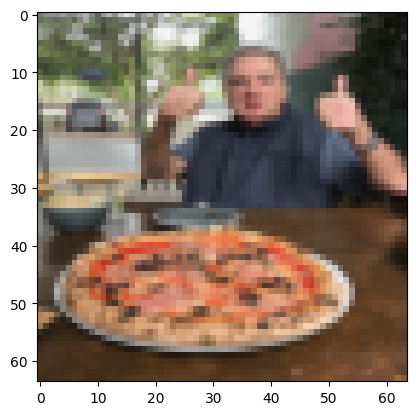

In [201]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [203]:
# Try to make a prediction on an image in uint8 format
# This will error no batch size
tiny_vgg_model.eval()
with torch.inference_mode():
  custom_image_pred = tiny_vgg_model(custom_image_transformed.to(device).unsqueeze(dim = 0))

In [204]:
# Convert logits -> prediction probabilities -> prediction labels
class_names[torch.softmax(custom_image_pred, dim = 1).argmax(dim = 1)]

'pizza'